# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.688348,True,7.193955
1,-0.797998,False,0.617240
2,-0.353316,False,0.291418
3,1.193718,True,6.298116
4,-0.368082,False,1.261607
...,...,...,...
995,-0.831889,False,-0.946847
996,0.976684,True,7.917534
997,-0.513582,False,0.289778
998,1.150319,True,5.587233


<AxesSubplot:xlabel='v0'>

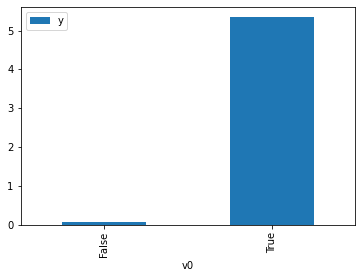

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

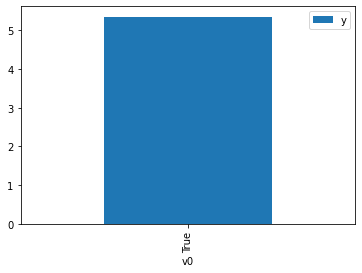

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.377580,False,-1.095144,0.710585,1.407290
1,-0.229745,False,-1.301415,0.638374,1.566480
2,-0.015565,False,-0.621863,0.522570,1.913621
3,-0.065029,False,0.773319,0.550014,1.818136
4,-0.644089,False,-0.483459,0.816525,1.224702
...,...,...,...,...,...
995,-0.417553,False,-0.479161,0.728581,1.372532
996,-0.028015,False,1.661720,0.529497,1.888586
997,0.631591,False,2.257412,0.205237,4.872416
998,-0.506494,False,-0.244950,0.766010,1.305466


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.503212,True,6.179304,0.964395,1.036919
1,1.266922,True,5.936373,0.941128,1.062555
2,0.956517,True,5.625072,0.888845,1.125056
3,2.760795,True,6.918581,0.997774,1.002231
4,1.072839,True,6.172794,0.912023,1.096464
...,...,...,...,...,...
995,2.007095,True,6.132486,0.988150,1.011992
996,0.892980,True,5.291443,0.874045,1.144106
997,-0.744275,True,6.488553,0.152315,6.565341
998,1.252529,True,5.538856,0.939323,1.064597


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              9529.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        21:40:26   Log-Likelihood:                         -1417.8
No. Observations:                1000   AIC:                                      2840.
Df Residuals:                     998   BIC:                                      2849.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9309      0.037     24.902      0.000       0.858       1.004
x2             4.9847      0.051     97.360      0.000       4.884       5.085
==============================================================================
Omnibus:                        0.568   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.625
Skew:                           0.054   Prob(JB):                        0.732
Kurtosis:                       2.944   Cond. No.                         2.07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""